In [12]:
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

# ---------------------------------------------------------------------------------------
#Используется весрия библиотеки 0.4.4, с другими версиями работа кода не гарантируется.
#Проверить версию, если implicit установлена print (implicit.__version__)
#Если implicit не установлена pip install implicit==0.4.4
#-----------------------------------------------------------------------------------------
import implicit 
import os 
os.environ['MKL_NUM_THREADS'] = '1' 

In [5]:
#загружаем и готовим данные
#для работы потребуется набор данных last.fm, скачать его можно по ссылке https://disk.yandex.ru/d/hVq6nXc4NSYpNQ
#набор даннх содержит информацию о пользователях, исполнителях и количестве прослушанных треков исполнителей этими пользователями
col_names = ["user_id", "artist_id", "artist_name", "total_plays"]
data = pd.read_csv('lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv', sep='\t', header=None, names=col_names)
#Посмотрим на данные 
data
#Видно, что у последних нескольких строк странные значения user_id

,user_id,artist_id,artist_name,total_plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
...,...,...,...,...
17535650,"sep 20, 2008",7ffd711a-b34d-4739-8aab-25e045c246da,turbostaat,12
17535651,"sep 20, 2008",9201190d-409f-426b-9339-9bd7492443e2,cuba missouri,11
17535652,"sep 20, 2008",e7cf7ff9-ed2f-4315-aca8-bcbd3b2bfa71,little man tate,11
17535653,"sep 20, 2008",f6f2326f-6b25-4170-b89d-e235b25508e8,sigur rós,10


In [6]:
#немного изучив данные, станет ясно, что это последние 48 элементов 
data.tail(49)
#Избавимся от них
data = data.query('user_id!="sep 20, 2008"')
#Посмотрим, есть ли в данных записи, где количество прослушиваний равно нулю. 
#Если такие записи есть, от них тоже нужно избавиться
data.query('total_plays==0')
#Выяснилось, что есть и записи с нулевыми прослушиваниями, а также есть пропущенные значения
#Удаляем пропущенные знаения, исключаем нулевые
data = data.dropna()
data = data.loc[data.total_plays != 0]

In [7]:
#Посмотрим описательные статистики 
data[['total_plays']].describe().applymap('{:,.2f}'.format)

,total_plays
count,"17,309,269.00"
mean,216.06
std,617.04
min,1.00
25%,35.00
50%,95.00
75%,225.00
max,"419,157.00"


In [8]:
#Посмотрим описательные статистики (см асимметрию и эксцесс)
from scipy import stats
stats.describe(data.total_plays)

DescribeResult(nobs=17309269, minmax=(1, 419157), mean=216.05671683766656, variance=380736.03986110486, skewness=91.91730945732057, kurtosis=30792.685766182083)

(array([5.69981001e-04, 1.10829639e-04, 3.16656111e-05, 4.74984167e-05,
        1.58328056e-05, 0.00000000e+00, 7.91640279e-06, 0.00000000e+00,
        0.00000000e+00, 7.91640279e-06]),
 array([  131. ,  1394.2,  2657.4,  3920.6,  5183.8,  6447. ,  7710.2,
         8973.4, 10236.6, 11499.8, 12763. ]),
 <a list of 10 Patch objects>)

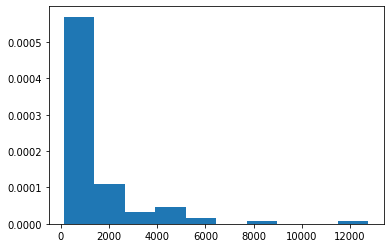

In [9]:
#Также посмотрим на распределение 
import matplotlib.pyplot as plt
plt.hist(data.head(100).total_plays, density=True)

У нас имеется довольно большое количество записей - более 17 млн. 
Однако, распределение не равномерное. Максимальное значение 419 157, но у 75% пользователей количество прослушиваний находится в диапазоне от 1 до 225
У распределения данных правосторонняя ассиметрия (skewness>0) и ярко выраженная острая вершина (kurtosis>0)
Тем не менее, в реальной правктике именно с такими данными и придется работать, поэтому имеем то, что имеем. 
Переходим к подготовке данных для модели. 

In [10]:
# Преобразовываем строковые идентификаторы к типу int, 
#поскольку библиотека implicit работает с идентификаторами в числовом формате
data['user_id'] = data['user_id'].astype("category")
data['artist_id'] = data['artist_id'].astype("category")
data['user_id'] = data['user_id'].cat.codes
data['artist_id'] = data['artist_id'].cat.codes

In [13]:
%%time

# Библиотека Implicit на вход ожидает матрицу "item-user"
# Создадим матрицу для обучения модели item-user
sparse_item_user = sparse.csr_matrix((data['total_plays'].astype(float), (data['artist_id'], data['user_id'])))

# Зададим параметры модели ALS для матрицы item-user
model = implicit.als.AlternatingLeastSquares(factors=25, regularization=0.1, iterations=25)

# Для расчета достоверности рекомендаций зададим значение коэффициента альфа.
alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')

#Обучим модель
model.fit(data_conf)


Wall time: 1min 21s


In [17]:
#---------------------
# Рекомендации похожих исполниелей
#---------------------

#Найдем 15 похожих на Britney Spears (id=102790), Britney Spears (id=43516), 50 Cent (id=89160)
item_id = 102790
n_similar = 15

# Передадим переменные в модель
similar = model.similar_items(item_id,  n_similar,  sparse_item_user)

#Посмотрим на список рекомендованных артистов и score
similar

[(102790, 1.0),
 (48085, 0.9998055),
 (31016, 0.9997814),
 (47392, 0.99972147),
 (89908, 0.99967027),
 (107851, 0.9996542),
 (75502, 0.9996404),
 (422, 0.9996276),
 (25249, 0.9996119),
 (126794, 0.9995822),
 (43093, 0.9995756),
 (17587, 0.9995581),
 (22289, 0.9995106),
 (111856, 0.9994923),
 (60405, 0.9994697)]

In [34]:
#Здесь указав ID из списка рекомендаций similar, мы можем оценить релевантность рекомендаций
data.query('artist_id==60405').head(1)

,user_id,artist_id,artist_name,total_plays
469,9,60405,rise against,85


В качестве бенчмарка посмотрим на похожих исполнителей, которых выводи яндекс <br>
Для Slipknot это <br>
* Korn <br>
* Disturbed <br>
* System of a Down <br>
* Rob Zombie <br>
* Marilyn Manson <br>
* Limp Bizkit <br> 
* Papa Roach <br>
* Bring Me The Horizon <br>

Наша модель рекомендует любителям Slipknit <br>
* 48085 = him <br> 
* 31016 = in flames <br>
* 47392 = disturbed <br>
* 89908 = limp bizkit <br>
* 107851 = koЯn <br>
* 75502 = apocalyptica <br> 
* 422 = nightwish <br>
* 25249 = dream theater <br>
* 126794 = iron maiden <br> 
* 43093 = mindless self indulgence <br>
* 17587 = afi	<br>
* 22289 = the offspring <br>
* 111856 = bloodhound gang <br>
* 60405 = rise against <br>

Кажется, довольно релевантный набор. <br>
Посмотрим, что нам порекомендует модель для поп исполнителей 

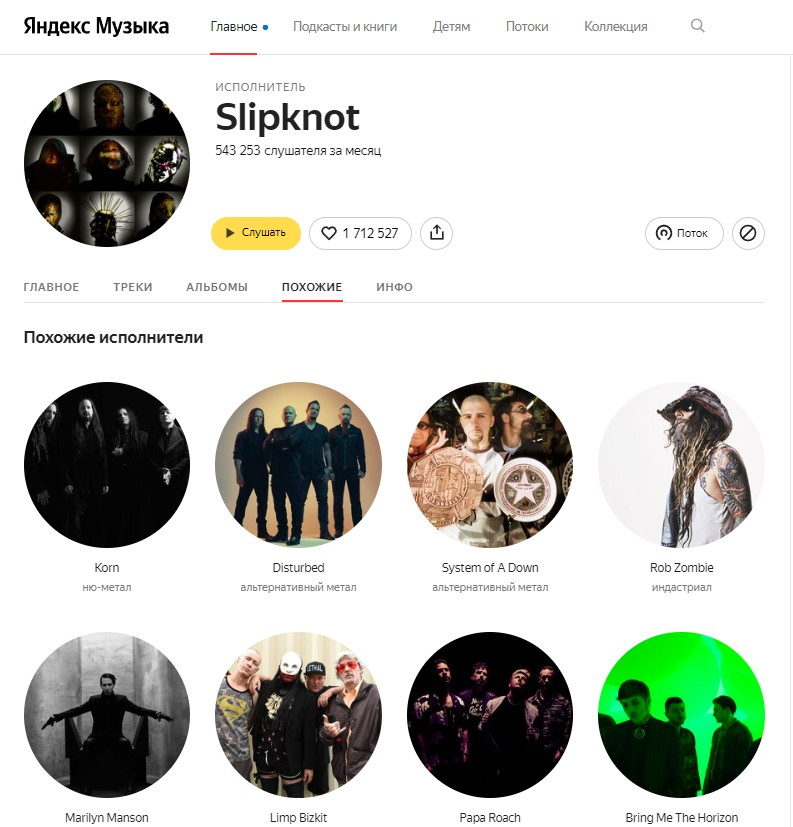

In [52]:
#---------------------
# Рекомендации похожих исполниелей
#---------------------

#Найдем 15 похожих на Britney Spears (id=102790), Britney Spears (id=43516), 50 Cent (id=89160)
item_id = 43516
n_similar = 15

# Передадим переменные в модель
similar = model.similar_items(item_id,  n_similar,  sparse_item_user)

#Посмотрим на список рекомендованных артистов и score
similar

[(43516, 1.0000001),
 (56020, 0.9997156),
 (12042, 0.9997124),
 (63331, 0.9996646),
 (658, 0.9996226),
 (75884, 0.99956053),
 (30060, 0.999538),
 (69018, 0.9994879),
 (47497, 0.9994778),
 (115927, 0.99947566),
 (133820, 0.99947065),
 (124508, 0.99945444),
 (151724, 0.9994473),
 (6678, 0.999399),
 (140969, 0.99939024)]

In [72]:
#Здесь указав ID из списка рекомендаций similar, мы можем оценить релевантность рекомендаций
data.query('artist_id==140969').head(1)

,user_id,artist_id,artist_name,total_plays
408,8,140969,mika,7


В качестве бенчмарка посмотрим на похожих исполнителей, которых выводи яндекс <br>
Для Britney Spears это <br>
* Beyoncé <br>
* Lady Gaga <br>
* Shakira <br>
* Christina Aguilera <br>
* Katy Perry <br>
* The Pussycat Dolls <br>
* Miley Cyrus <br>
* Black Eyed Peas <br>

Наша модель рекомендует любителям Britney Spears <br>
* 56020 = justin timberlake <br>
* 12042 = nelly furtado <br>
* 63331 = lady gaga <br>
* 658 = avril lavigne	<br>
* 75884 = madonna <br>
* 30060 = kylie minogue <br>
* 69018 = lily allen <br>
* 47497 = alanis morissette <br>
* 115927 = eminem <br>
* 133820 = black eyed peas <br>
* 124508 = keane <br>
* 151724 = michael jackson <br>
* 6678 = maroon 5 <br>
* 140969 = mika <br>

Конечно нет 100% пересечения, но его и не должно быть. В целом результат также релевантен. <br>
Теперь проверим рекоменации на рэп исполнителе. 

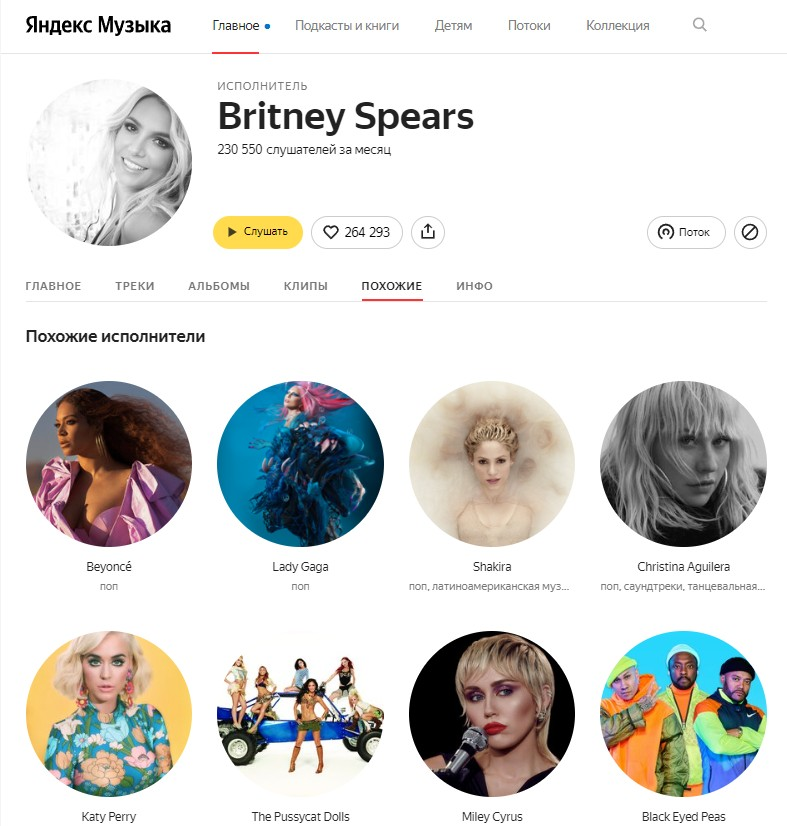

In [98]:
#---------------------
# Рекомендации похожих исполниелей
#---------------------

#Найдем 15 похожих на Britney Spears (id=102790), Britney Spears (id=43516), 50 Cent (id=89160)
item_id = 89160
n_similar = 15

# Передадим переменные в модель
similar = model.similar_items(item_id,  n_similar,  sparse_item_user)

#Посмотрим на список рекомендованных артистов и score
similar

[(89160, 1.0000001),
 (155770, 0.9987626),
 (136878, 0.9987329),
 (35194, 0.9987249),
 (133820, 0.9984624),
 (56020, 0.9984609),
 (72624, 0.99818707),
 (155218, 0.99805254),
 (63331, 0.99801326),
 (107907, 0.9978203),
 (12042, 0.99781835),
 (43516, 0.99762696),
 (89498, 0.99755925),
 (145558, 0.99753827),
 (72670, 0.9974262)]

In [115]:
#Здесь указав ID из списка рекомендаций similar, мы можем оценить релевантность рекомендаций
data.query('artist_id==72670').head(1)

,user_id,artist_id,artist_name,total_plays
4178,85,72670,outkast,59


В качестве бенчмарка посмотрим на похожих исполнителей, которых выводи яндекс <br>
Для 50 Cent это <br>
* Snoop Dogg <br>
* Dr. Dre <br>
* Akon <br>
* Jay-Z <br>
* Eminem <br>
* DMX <br>
* Kanye West <br>
* Black Eyed Peas <br>

Наша модель рекомендует любителям 50 Cent <br>
* 155770 = snoop dogg <br>
* 136878 = timbaland <br>
* 35194 = 2pac <br>
* 133820 = black eyed peas <br>
* 56020 = justin timberlake <br>
* 72624 = rihanna <br>
* 155218 = jay-z <br>
* 63331 = lady gaga <br>
* 107907 = lil wayne <br>
* 12042 = nelly furtado <br>
* 43516 = britney spears <br>
* 89498 = alicia keys <br>
* 145558 = matisyahu <br>
* 72670 = outkast <br> 

В целом рекоменации тоже релевантны. <br> 
Вообще для любой рекомендательной системы актуальна проблема объяснения "почему мы это порекомендовали", например, почему вместе с 50 Cent рекоменжуется Nelly Furtado. <br> 
Однако, здесь в первую очередь важно оценить модель. Дополнительный тюнинг целесообразно делать на уровне фильтрации и формирования выборок. <br> 
Например, формировать выборку только из тех, треков, которые пользователь прослушал больше определенного времени. <br> 
Или брать треки только определенного жанра. <br> 
Здесь уже поле для экпериментов. 

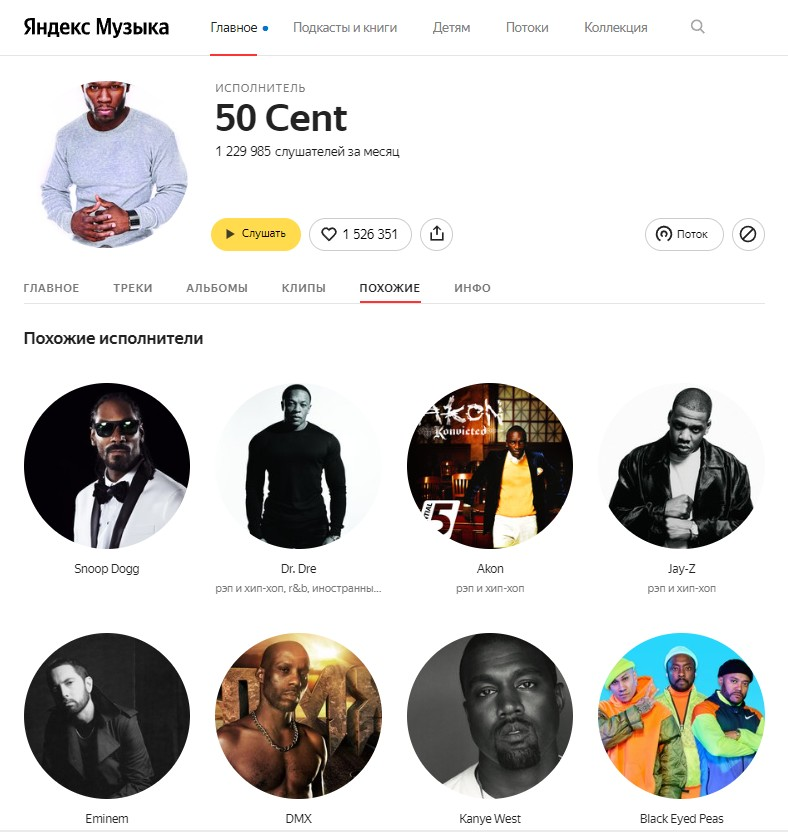

In [96]:
#Если есть желание, можно попробовать найти исполнителя по имени, взять его ID и передать в модель
data.query('artist_name=="50 cent"').sort_values(by='total_plays')

,user_id,artist_id,artist_name,total_plays
4687053,95905,89160,50 cent,1
7111987,145494,89160,50 cent,1
16611504,339916,89160,50 cent,1
13857678,283562,89160,50 cent,1
13653465,279403,89160,50 cent,1
...,...,...,...,...
9510288,194533,89160,50 cent,12158
7304518,149426,89160,50 cent,13211
7113561,145527,89160,50 cent,13444
1464688,29967,89160,50 cent,15166
